In [70]:
import pandas as pd
import numpy as np
from numpy import newaxis

import random
import itertools

import os
from os import listdir
from os.path import isfile
import math

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.collections
from matplotlib import gridspec

import datetime
from tqdm import *

import keras
from keras.applications import *
import lightgbm as lgbm

from scipy import ndimage
from scipy import misc
from scipy import signal
import cv2
plt.ion()
plt.show()

import keras

from keras.layers import Input, Dense, Lambda, Layer, Conv2D, MaxPooling2D,UpSampling2D, concatenate, Dropout,Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras import metrics


import collections
from collections import *

import tensorflow as tf
from IPython.display import clear_output
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


![title](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [4]:
# !dir data/stage1_test

In [5]:
trainDir = 'data/stage1_train/'
testDir = 'data/stage1_test/'
unetSize = 256

In [6]:
fileIDs = listdir(trainDir)
testIDs = listdir(testDir)

In [7]:
def getFileImage(fileID, dd=trainDir):
    if not os.path.isfile(dd + fileID + '/images/'+ fileID + '.png'):
        print(f'Missing image file with ID {fileID}')
        return None
    else:
        return misc.imread(dd + fileID + '/images/'+fileID + '.png')

In [8]:
def drawContour(x):
    res = signal.convolve2d(x, [[1,1,1],[1,1,1],[1,1,1]], 'same')
    indices = np.where((res/255 < 9) & (x == 255)==True)
    x[indices[0],indices[1]] = 128
    return x

def getFileMasks(fileID):
    if not os.path.isdir(trainDir + fileID + '/masks/'):
        print(f'Missing mask file with ID {fileID}')
        return None
    else:
        theMask = None
        for mask in listdir(trainDir + fileID + '/masks/'):
            m = misc.imread(trainDir + fileID + '/masks/' + mask)
            m = drawContour(m)
            if theMask is None:
                theMask = m
            else:
                theMask = theMask + m
        return theMask
        


In [9]:
def splitMask(mask):
    allMasks = []
    whitePixels = list(zip(*np.where(mask == 255)))
    while len(whitePixels) > 0 :
        pixels = getMaskPixels(whitePixels[0][0],whitePixels[0][1], mask)

        whitePixels = [p for p in whitePixels if p not in pixels]
        
        pixels = list(zip(*pixels))
        mask[pixels[0],pixels[1]] = 0
        
        m = np.zeros(mask.shape)
        m[pixels[0],pixels[1]] = 255
        allMasks.append(m)       
    return allMasks

# plt.imshow(mask, cmap = 'gray')
# for i in splitMask(mask.copy()):
#     plt.imshow(i, cmap = 'gray')
#     plt.figure()



In [10]:
def getMaskPixels(i,j, mask):
    result = np.zeros(mask.shape)
    result[i,j] = 255
    neighbors = [] + []

    toiterate = []

    toiterate.append((i,j))
    idx = 0
    while (idx < len(toiterate)):
#         print(toiterate)
        idxx = toiterate[idx][0]
        idxy = toiterate[idx][1]

        for newelem in [ (idxx+x,idxy+y) 
                    for x,y in itertools.product(range(-1,2), range(-1,2)) 
                    if  idxx+x < mask.shape[0] and idxx+x >= 0 and
                        idxy+y < mask.shape[1] and idxy+y >= 0 and
                        mask[idxx+x,idxy+y]==255 and not((idxx+x,idxy+y) in toiterate)]:
            toiterate.append(newelem)

        idx = idx+1
#         print(idx, len(toiterate))

    return toiterate
    
# getMaskPixels(1, 14, mask)

In [11]:
def getSubmissionForFile(fileID, masks):
    print(f'Found {len(masks)}')
    results = []
    for mask in masks:
        whitePixels = np.where(np.reshape(mask,-1, order='F')==255)[0]+1
#         print(len(whitePixels))
        result = []
        last = whitePixels[0]
        lastlen = 0

        for i in whitePixels:
            if i != last+1:
                result.append(lastlen+1)
                result.append(i)
                lastlen=0
            else:
                lastlen = lastlen+1
            last = i
        result.append(lastlen+1)
        results.append(result[1:])
    return results

In [46]:
def imgResizeNormalizeAndGrayscale(img, newDimension, normalize = True, grayscale = True):

        
    # todo: check both dimensions, or either
    if img.shape[0] > newDimension[0]: 
        img = cv2.resize(img,newDimension, cv2.INTER_AREA)
    else:
        img = cv2.resize(img,newDimension, cv2.INTER_CUBIC)
        
    if normalize :
        img = cv2.normalize(img, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F, dst=None)
    # convert image to grayscale only if it has 3 dimensions - it is not already grayscale
    if grayscale and len(img.shape) > 2 and img.shape[2] > 1:
        img = cv2.cvtColor( img, cv2.COLOR_RGB2GRAY )
    return img
    
    

(256, 320, 4)


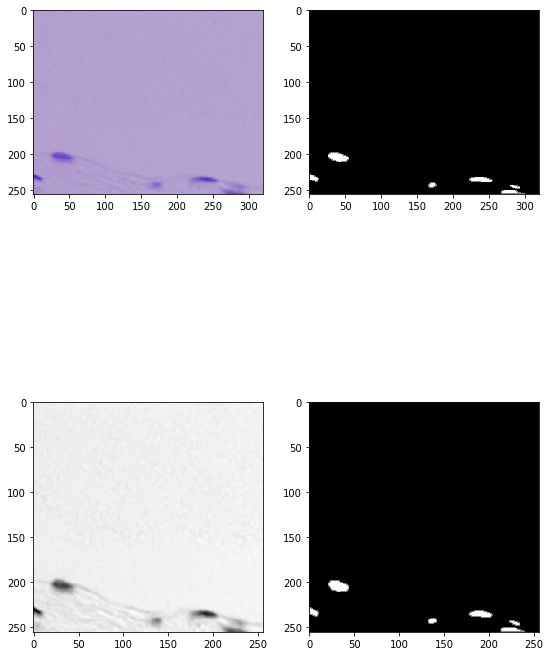

In [47]:

def evaluateImage(imageID, model=None):
    plt.figure(figsize=(14,14))

    img = getFileImage(fileIDs[imageID])

    print(img.shape)
    plt.subplot(231)
    plt.grid(False)
    plt.imshow(img, cmap='gray')
    plt.subplot(234)
    plt.grid(False)
    plt.imshow(imgResizeNormalizeAndGrayscale(img, (unetSize,unetSize)), cmap='gray')

    if model is not None:
        pred = model.predict(imgResizeNormalizeAndGrayscale(img,(unetSize,unetSize))[newaxis,:,:,:3])[0,:,:,0]
        print(pred.shape)
        plt.subplot(233)
        plt.grid(False)
        plt.imshow(pred, cmap='gray')
        plt.subplot(236)
        plt.grid(False)
        plt.imshow(imgResizeNormalizeAndGrayscale(pred, (unetSize,unetSize)), cmap='gray')
    
    img = getFileMasks(fileIDs[imageID])
    plt.subplot(232)
    plt.grid(False)
    plt.imshow(img, cmap='gray')
    plt.subplot(235)
    plt.grid(False)
    plt.imshow(imgResizeNormalizeAndGrayscale(img,(unetSize,unetSize)), cmap='gray')
    


evaluateImage(40)

In [59]:
if os.path.isfile('data/inputImgGrayscaleNormalized.npy'):
    inputImg = np.load('data/inputImgGrayscaleNormalized.npy')
    masks = np.load('data/masksGrayscaleNormalized.npy')
else:
    inputImg = []
    masks = []
    for fileId in fileIDs:
        print('.', end ='')
        inputImg.append(imgResizeNormalizeAndGrayscale(getFileImage(fileId), (unetSize, unetSize)))
        masks.append(imgResizeNormalizeAndGrayscale(getFileMasks(fileId), (unetSize, unetSize)))
    inputImg = np.stack(inputImg)
    inputImg = inputImg[:,:,:, newaxis]
    masks = np.stack(masks)
    masks = masks[:,:,:, newaxis]
    np.save('data/masksGrayscaleNormalized.npy', masks)
    np.save('data/inputImgGrayscaleNormalized.npy', inputImg)
    
    
    
masks.shape
inputImg.shape

(670, 256, 256, 1)

(670, 256, 256, 1)

In [17]:
# !rm data/*.npy

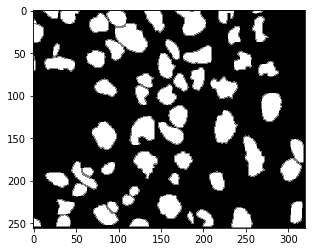

In [60]:
fileID = fileIDs[0]
plt.grid(False)
mask = getFileMasks(fileID)
plt.imshow(mask, cmap = 'gray')

In [3]:
# i = 5

# for x in range(5):
#     i = random.randint(0,len(fileIDs)-1)
#     evaluateImage(i)

## U net

In [21]:
# inputImg = []
# masks = []

![title](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [22]:
# model PC1

In [67]:
# imgsize = unetSize
# inp = Input(shape=(imgsize,imgsize,1), name='input')

# channels = 64
# x = Conv2D(channels, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(inp)
# x_512 = Conv2D(channels, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(x)

# x = MaxPooling2D(pool_size=(2, 2), padding='same')(x_512)

# channels = 128
# x = Conv2D(channels, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(x)
# x_256 = Conv2D(channels, (3,3), activation='relu', padding='same')(x)



# channels = channels * 2
# x = Conv2D(channels, (3,3),activation='elu', kernel_initializer='he_normal', padding='same')(x)
# x_128 = Conv2D(channels, (3,3), activation='elu', kernel_initializer='he_normal',padding='same')(x)


# x = UpSampling2D((2, 2))(x_256)

# c = concatenate([x_512,x])

# x = Conv2D(channels, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(c)
# channels =64
# x = Conv2D(channels, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(x)
# x = Conv2D(channels, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(x)

# out = Conv2D(1, (1,1), activation='sigmoid', padding='same')(x)


# unetAE = Model(inp,out)
# unetAE.compile(optimizer='adadelta', loss='binary_crossentropy')

# unetAE.summary()


# x = MaxPooling2D(pool_size=(2, 2), padding='same')(x_128)


In [71]:
imgsize = unetSize

def uconvx2(x, channels):
    x = Conv2D(channels, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(x)
    x = Dropout(0.1) (x)
    x = Conv2D(channels, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(x)
    return x

def uConvDown(x, channels):
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = uconvx2(x, channels)
    return x

def uConvUp(x, grey, channels):
    x = UpSampling2D((2, 2))(x)
    x = uconvx2(concatenate([x,grey]), channels)
    return x

inp = Input(shape=(imgsize,imgsize,1), name='input')

startChannel = 64
numChannels = 4
layer = []

layer.append(uconvx2(inp, startChannel))
for i in range(1, numChannels+1):
    layer.append(uConvDown(layer[-1],startChannel*(2**i)))

middle = layer[-1]

for i in range(numChannels+1,1,-1):
    layer.append(uConvUp(layer[-1], layer[i-2], startChannel*(2**i)))

out = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(layer[-1])


mid = Model(inp, middle)
unetAE = Model(inp,out)
unetAE.compile(optimizer='adadelta', loss='binary_crossentropy')

unetAE.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input (InputLayer)               (None, 256, 256, 1)   0                                            
____________________________________________________________________________________________________
conv2d_69 (Conv2D)               (None, 256, 256, 64)  640         input[0][0]                      
____________________________________________________________________________________________________
dropout_28 (Dropout)             (None, 256, 256, 64)  0           conv2d_69[0][0]                  
____________________________________________________________________________________________________
conv2d_70 (Conv2D)               (None, 256, 256, 64)  36928       dropout_28[0][0]                 
___________________________________________________________________________________________

In [72]:

class PlotLosses(keras.callbacks.Callback):
    def __init__(self):
        self.initVars()
    
    def initVars(self):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = [] # self validation
        self.fig = plt.figure()
        self.logs = []
        self.lr = []
        
    def on_train_begin(self, logs={}):
        ;
#         self.initVars()

    def on_epoch_end(self, epoch, logs={}):
        
        self.i += 1
        
        curloss = logs.get('loss')
        self.losses.append(curloss)
        self.val_losses.append(logs.get('val_loss'))
        self.logs.append(logs)
#         self.x.append(self.i)
        
        clear_output(wait=True)
        plt.figure(figsize=(16,10))
        ax = plt.subplot(133)
        self.plotLosses(ax)
#         self.plotProgress(ax)
        plt.show()

    def plotLosses(self, ax):
        plt.plot(np.arange(len(self.losses)), self.losses, label="train loss")
        plt.plot(np.arange(len(self.losses)), self.val_losses, label="val loss")

        plt.legend()

        
myPlotLosses = PlotLosses()
# myPlotLosses.initVars()

In [ ]:
batchSize = 3
for i in range(0, len(inputImg), 20) :
#     x_train = inputImg[i: (i + 20)][:,:,:,:3]/255.0
#     y_train = masks[i: (i + 20)]/255.0
#     unetAE.fit(x_train, y_train,
    unetAE.fit(inputImg, masks, epochs=50, batch_size=batchSize, shuffle=True, verbose=1 ,callbacks=[myPlotLosses]
#                 validation_data=(x_test, x_test),
              )

Epoch 1/50


In [ ]:
pred = unetAE.predict(inputImg[570:575][:,:,:,:3])

(256, 256)


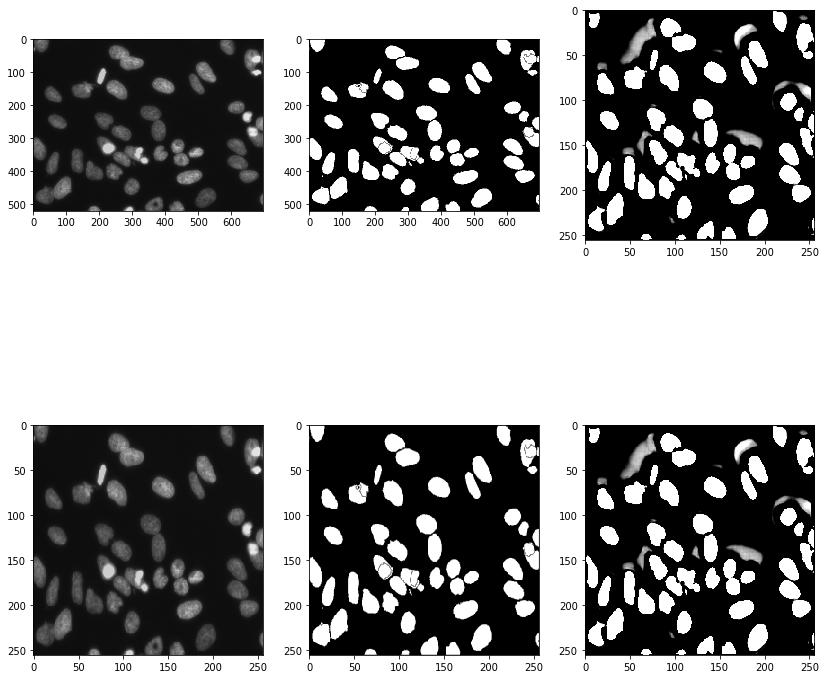

In [37]:
evaluateImage(650, unetAE)

In [ ]:
testIDs

In [ ]:
# testIDs = fileIDs[0:3]
model = unetAE

In [ ]:
encodedPredictions = {}
for fileID in testIDs:
    img = getFileImage(fileID, testDir)
    pred = model.predict(imgResizeNormalizeAndGrayscale(img,(512,512))[newaxis,:,:,:3])[0,:,:,0]
    print(img.shape, img.shape[:2])
    pred = np.round(imgResizeNormalizeAndGrayscale(pred, img.shape[:2]) ) * 255
    plt.imshow(pred, cmap = 'gray')
    encodedPredictions[fileID] = getSubmissionForFile(fileID,splitMask(pred))
#     break
    
encodedPredictions    

In [ ]:
plt.imshow(img)

In [ ]:
encodedPredictions.keys()

In [ ]:
from datetime import *
datetime.now()

In [ ]:
sub = pd.DataFrame(columns=['ImageId','EncodedPixels'])
print(len(sub))

for key,value in encodedPredictions.items():
    for nuclei in value:
        sub.loc[len(sub),:] = [key, ' '.join(map(str, nuclei))]

In [ ]:
filename = 'data/submission' + datetime.now().strftime('%Y-%m-%d_%H-%M')+ '.csv.gzip'

sub.to_csv(filename, compression='gzip', index=False)

In [ ]:
filename = 'data/submission' + datetime.now().strftime('%Y-%m-%d_%H-%M')+ '.csv'
file = open(filename,'w') 

file.write('ImageId\tEncodedPixels\n')
for key,value in encodedPredictions.items():
    for nuclei in value:
        file.write(key + '\t' + ' '.join(map(str, nuclei)) + '\n')
file.close() 



In [ ]:
!ls -al 'data/'